In [1]:
%matplotlib inline
import data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
idd, seq = data.readseq('train.csv')

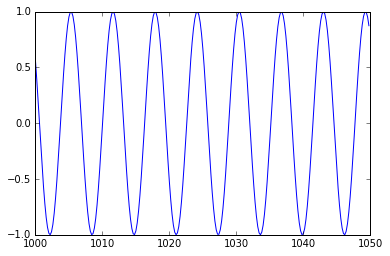

In [139]:
x = np.arange(1000, 1050, step=0.2)
y = np.cos(x)
plt.plot(x, y)
plt.show()

In [148]:
def get_batch(s, ix):
    t = s[ix]
    return t[:-1], t[1:]
def sine_data(ix,size=50):
    x = np.arange(ix, ix + size, step = 0.2)
    y = np.cos(x)
    return y[:-1], y[1:]

In [198]:
inp_out_size = 1
hidden_layer_size = 20
lr = 0.01
epoch = 1600
print_step = 200
num_steps = 22

In [199]:
# zoneout as in https://arxiv.org/pdf/1606.01305v1.pdf
def zoneout(h, h_prev):
    assert h.get_shape() == h_prev.get_shape()
    r = tf.select(tf.random_uniform(h.get_shape()) > keep, tf.ones_like(h), tf.zeros_like(h))
    h_z = tf.mul(r, h_prev) + tf.mul(tf.sub(tf.ones_like(r), r), h)
    return h_z

In [200]:
tf.reset_default_graph()
initializer = tf.random_uniform_initializer(minval=-0.01, maxval=0.01, dtype=tf.float32)
Wxh = tf.get_variable('Wxh', shape=[inp_out_size, hidden_layer_size], initializer=initializer)
Whh = tf.get_variable('Whh', shape=[hidden_layer_size, hidden_layer_size], initializer=initializer)
Why = tf.get_variable('Why',shape=[hidden_layer_size, inp_out_size], initializer=initializer)
# weights associated with update gate
Wxz = tf.get_variable('Wxz', shape=[inp_out_size, hidden_layer_size], initializer=initializer)
Whz = tf.get_variable('Whz', shape=[hidden_layer_size, hidden_layer_size], initializer=initializer)
# weights associated with the reset gate
Wxr = tf.get_variable('Wxr', shape=[inp_out_size, hidden_layer_size], initializer=initializer)
Whr = tf.get_variable('Whr', shape=[hidden_layer_size, hidden_layer_size], initializer=initializer)

In [201]:
def GRU(prev, inp):
    i = tf.reshape(inp, shape=[1, -1])
    p = tf.reshape(prev, shape=[1, -1])
    z = tf.nn.sigmoid(tf.matmul(i, Wxz) + tf.matmul(p, Whz))    # update gate
    r = tf.nn.sigmoid(tf.matmul(i, Wxr) + tf.matmul(p, Whr))    # reset gate
    h_ = tf.nn.tanh(tf.matmul(i, Wxh) + tf.matmul(tf.mul(p, r), Whh))
    h = tf.mul(tf.sub(tf.ones_like(z), z), h_) + tf.mul(z, p)
#     h = zoneout(h, p)
    return tf.reshape(h, [hidden_layer_size])

In [202]:
# model
inputs = tf.placeholder(shape=[None, 1], dtype=tf.float32)
targets = tf.placeholder(shape=[None, 1], dtype=tf.float32)
keep = tf.placeholder(dtype=tf.float32)
initial = tf.placeholder(shape=[hidden_layer_size], dtype=tf.float32)
hiddens = tf.scan(GRU, inputs, initializer=initial)
outputs = tf.matmul(hiddens, Why)
loss = tf.sqrt(tf.reduce_sum(tf.square(tf.sub(outputs, targets))))
optimizer = tf.train.AdagradOptimizer(lr)
grad = optimizer.compute_gradients(loss, [Wxh])[0]
optimize_op = optimizer.minimize(loss)

In [239]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [240]:
ix = 0
ini = np.zeros([hidden_layer_size])

In [241]:
for i in range(epoch):
    a, b = sine_data(ix, size=num_steps)    
    a = np.reshape(a, [-1, 1])
    b = np.reshape(b, [-1, 1])
    feed = {inputs: a, targets: b, initial: ini, keep: 0.7}
    l, h, _ = sess.run([loss, hiddens, optimize_op], feed_dict=feed)
    ix += 1
    if i % print_step == 0:
        print('epoch', i, 'Loss', l)
    ix += num_steps
    ini = h[-1]

epoch 0 Loss 7.34913
epoch 200 Loss 2.07854
epoch 400 Loss 0.284631
epoch 600 Loss 0.351159
epoch 800 Loss 0.471057
epoch 1000 Loss 0.550787
epoch 1200 Loss 0.377051
epoch 1400 Loss 0.119364


In [235]:
def generate(sess, n):
    global ix
    print(ix)
    ixx = [[ix]]
    v = []
    h = np.zeros(hidden_layer_size)
    for i in range(n):
        o, h = sess.run([outputs, hiddens], {inputs:ixx, initial: h, keep: 1.0})
        h = h.reshape(hidden_layer_size)
        ixx = o
        v.append(np.squeeze(o))
    return v

In [236]:
print(ix)

36801


36800
0.211705179122


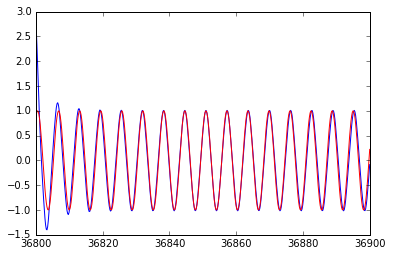

In [242]:
x = np.arange(ix, ix + 100, step = 0.2)
pred = np.array(generate(sess, len(x)))
true = np.cos(x)
test_loss = np.sqrt(np.mean((true - pred) ** 2))
print(test_loss)
plt.plot(x, pred, 'b-')
plt.plot(x, true, 'r-')
plt.show()